In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
from astropy.time import Time
import astropy.units as u

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

np.random.seed(42)

print(tf.__version__)

1.13.1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load data and make some subsets for each wfs for inspection later
dfs = []
for y in [2017, 2018, 2019]:
    dfs.append(pd.read_csv(f"../raw_data/{y}_wfs.csv"))
data = pd.concat(dfs)
data['ut'] = pd.to_datetime(data.ut)
data['az'][data['az'] < 0.] += 360.

f9 = data[(data['wfs'] == 'newf9') | (data['wfs'] == 'oldf9')]
f5 = data[data['wfs'] == 'f5']
mmirs = data[data['wfs'] == 'mmirs']
bino = data[data['wfs'] == 'binospec']

/Users/tim/conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [4]:
f9.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr
0,2017-01-05 01:12:45,1.42,253.51,-0.000,3.770,3.8,44.65,5.0,auto_wfs_0000.fits,-17.43,...,286.68,99.81,2017-01-05T01:12:45,416.83,-32.26,542.288992,oldf9,226.015353,250.007036,3.770000
1,2017-01-05 01:16:13,1.44,254.17,0.080,0.000,3.5,43.94,5.0,auto_wfs_0012_ave.fits,-18.52,...,302.72,134.49,2017-01-05T01:16:13,186.35,70.24,486.138629,oldf9,265.364335,261.636554,0.080000
2,2017-01-05 01:44:37,1.26,178.61,0.000,0.524,4.8,52.57,6.0,auto_wfs_0016.fits,-4.54,...,314.86,129.55,2017-01-05T01:44:37,267.65,380.95,360.223957,oldf9,250.626314,245.077563,0.524000
3,2017-01-05 01:45:31,1.26,178.98,4.062,0.112,4.9,52.58,6.0,auto_wfs_0019.fits,8.34,...,316.68,144.65,2017-01-05T01:45:31,121.03,405.37,1103.120836,oldf9,257.194046,282.253175,4.063544
4,2017-01-05 01:45:31,1.26,178.98,2.577,-0.000,4.9,52.58,6.0,auto_wfs_0019_ave.fits,11.81,...,316.68,144.65,2017-01-05T01:45:31,121.03,405.37,1274.692349,oldf9,256.104257,280.132964,2.577000


In [5]:
data.columns

Index(['ut', 'airmass', 'az', 'cc_x_err', 'cc_y_err', 'chamt', 'el', 'exptime',
       'file', 'focerr', 'focus', 'fwhm', 'osst', 'outt', 'raw_seeing',
       'residual_rms', 'seeing', 'tiltx', 'tilty', 'time', 'transx', 'transy',
       'wavefront_rms', 'wfs', 'xcen', 'ycen', 'comaerr'],
      dtype='object')

In [6]:
# wrangle the times to add colums for mjd to look for trends over time and hour to look for nightly trends
raw_times = data['time']
times = Time(raw_times.values.tolist(), format='isot', scale='utc')
mjd = times.mjd
data['mjd'] = mjd.tolist()
data['hour'] = data['ut'].dt.hour
data.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
0,2017-01-05 01:12:45,1.42,253.51,-0.000,3.770,3.8,44.65,5.0,auto_wfs_0000.fits,-17.43,...,2017-01-05T01:12:45,416.83,-32.26,542.288992,oldf9,226.015353,250.007036,3.770000,57758.050521,1
1,2017-01-05 01:16:13,1.44,254.17,0.080,0.000,3.5,43.94,5.0,auto_wfs_0012_ave.fits,-18.52,...,2017-01-05T01:16:13,186.35,70.24,486.138629,oldf9,265.364335,261.636554,0.080000,57758.052928,1
2,2017-01-05 01:44:37,1.26,178.61,0.000,0.524,4.8,52.57,6.0,auto_wfs_0016.fits,-4.54,...,2017-01-05T01:44:37,267.65,380.95,360.223957,oldf9,250.626314,245.077563,0.524000,57758.072650,1
3,2017-01-05 01:45:31,1.26,178.98,4.062,0.112,4.9,52.58,6.0,auto_wfs_0019.fits,8.34,...,2017-01-05T01:45:31,121.03,405.37,1103.120836,oldf9,257.194046,282.253175,4.063544,57758.073275,1
4,2017-01-05 01:45:31,1.26,178.98,2.577,-0.000,4.9,52.58,6.0,auto_wfs_0019_ave.fits,11.81,...,2017-01-05T01:45:31,121.03,405.37,1274.692349,oldf9,256.104257,280.132964,2.577000,57758.073275,1


In [7]:
e_series_2019 = pd.read_csv("../halcoll/data/halcoll_temps.csv")
e_series_2019.head()

,ts,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
0,2016-01-01 00:00:00,1.82905,1.71735,1.7748,1.6990,1.78825,1.8217,1.54470,1.633,1.8,1.8,2.0,1.8,1.7,1.9,1.8
1,2016-01-01 00:05:00,1.82340,1.68600,1.7659,1.6806,1.76570,1.8120,1.53410,1.588,1.7,1.8,1.9,1.8,1.7,1.9,1.8
2,2016-01-01 00:10:00,1.82435,1.70410,1.7618,1.6727,1.75620,1.8087,1.52885,1.658,1.8,1.8,1.9,1.9,1.7,1.8,1.8
3,2016-01-01 00:15:00,1.81050,1.71710,1.7481,1.6543,1.75790,1.7965,1.54970,1.724,1.7,1.8,1.9,1.8,1.7,1.9,1.9
4,2016-01-01 00:20:00,1.81450,1.76420,1.7586,1.6753,1.78190,1.8041,1.61250,1.723,1.8,1.8,1.9,1.8,1.7,1.8,1.9


In [8]:
fixed = data.drop(columns=['ut']).set_index(pd.DatetimeIndex(data['time'], name='ut'))
fixed.head()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
ut,,,,,,,,,,,,,,,,,,,,,
2017-01-05 01:12:45,1.42,253.51,-0.000,3.770,3.8,44.65,5.0,auto_wfs_0000.fits,-17.43,645.94,...,2017-01-05T01:12:45,416.83,-32.26,542.288992,oldf9,226.015353,250.007036,3.770000,57758.050521,1
2017-01-05 01:16:13,1.44,254.17,0.080,0.000,3.5,43.94,5.0,auto_wfs_0012_ave.fits,-18.52,564.54,...,2017-01-05T01:16:13,186.35,70.24,486.138629,oldf9,265.364335,261.636554,0.080000,57758.052928,1
2017-01-05 01:44:37,1.26,178.61,0.000,0.524,4.8,52.57,6.0,auto_wfs_0016.fits,-4.54,756.57,...,2017-01-05T01:44:37,267.65,380.95,360.223957,oldf9,250.626314,245.077563,0.524000,57758.072650,1
2017-01-05 01:45:31,1.26,178.98,4.062,0.112,4.9,52.58,6.0,auto_wfs_0019.fits,8.34,799.59,...,2017-01-05T01:45:31,121.03,405.37,1103.120836,oldf9,257.194046,282.253175,4.063544,57758.073275,1
2017-01-05 01:45:31,1.26,178.98,2.577,-0.000,4.9,52.58,6.0,auto_wfs_0019_ave.fits,11.81,799.59,...,2017-01-05T01:45:31,121.03,405.37,1274.692349,oldf9,256.104257,280.132964,2.577000,57758.073275,1


In [9]:
e_series = e_series_2019.set_index(pd.DatetimeIndex(e_series_2019['ts'], name='ut').tz_localize('MST').tz_convert(None)).drop(columns=['ts'])
e_series.head()

,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
ut,,,,,,,,,,,,,,,
2016-01-01 07:00:00,1.82905,1.71735,1.7748,1.6990,1.78825,1.8217,1.54470,1.633,1.8,1.8,2.0,1.8,1.7,1.9,1.8
2016-01-01 07:05:00,1.82340,1.68600,1.7659,1.6806,1.76570,1.8120,1.53410,1.588,1.7,1.8,1.9,1.8,1.7,1.9,1.8
2016-01-01 07:10:00,1.82435,1.70410,1.7618,1.6727,1.75620,1.8087,1.52885,1.658,1.8,1.8,1.9,1.9,1.7,1.8,1.8
2016-01-01 07:15:00,1.81050,1.71710,1.7481,1.6543,1.75790,1.7965,1.54970,1.724,1.7,1.8,1.9,1.8,1.7,1.9,1.9
2016-01-01 07:20:00,1.81450,1.76420,1.7586,1.6753,1.78190,1.8041,1.61250,1.723,1.8,1.8,1.9,1.8,1.7,1.8,1.9


In [10]:
merged = pd.merge_asof(fixed.sort_index(), e_series, on='ut')
merged.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
0,2016-02-11 23:12:25.117,1.1153,186.873714,0.720,-0.637,16.911,63.717322,10.0,f9wfs_20171023-214204.fits,0.00,...,10.7028,19.5691,13.974,13.8,13.8,12.6,15.3,14.1,13.8,12.7
1,2016-02-12 00:20:13.051,1.2475,183.036610,-1.440,-0.000,8.164,53.286308,10.0,f9wfs_20171020-215029.fits,-0.00,...,11.0770,21.3626,14.191,14.4,14.3,13.1,15.8,14.7,14.4,13.1
2,2016-02-12 02:29:16.982,1.5157,239.629020,-3.606,-2.048,16.739,41.280837,10.0,f9wfs_20171024-005856.fits,-0.37,...,10.9224,10.1409,11.019,12.8,12.8,12.1,10.6,12.7,12.9,12.2
3,2016-02-12 03:38:53.982,1.2768,290.512635,-2.219,-0.000,7.405,51.553934,10.0,f9wfs_20171021-010909.fits,15.19,...,10.7880,9.8597,10.755,10.8,11.6,11.4,9.6,10.9,11.7,11.4
4,2016-02-12 03:40:58.063,1.2842,290.593852,0.000,2.283,7.269,51.141871,10.0,f9wfs_20171021-011113.fits,-0.00,...,10.7709,9.9240,10.661,10.7,11.6,11.4,9.8,10.8,11.6,11.4


In [11]:
merged.columns

Index(['ut', 'airmass', 'az', 'cc_x_err', 'cc_y_err', 'chamt', 'el', 'exptime',
       'file', 'focerr', 'focus', 'fwhm', 'osst', 'outt', 'raw_seeing',
       'residual_rms', 'seeing', 'tiltx', 'tilty', 'time', 'transx', 'transy',
       'wavefront_rms', 'wfs', 'xcen', 'ycen', 'comaerr', 'mjd', 'hour',
       'cell_e_series_backplate_C', 'cell_e_series_chamber_ambient_C',
       'cell_e_series_frontplate_C', 'cell_e_series_in_front_of_primary_C',
       'cell_e_series_lower_plenum_C', 'cell_e_series_midplate_C',
       'cell_e_series_outside_ambient_C', 'yankee_temperature',
       'temptrax1_probe2', 'temptrax1_probe3', 'temptrax1_probe4',
       'temptrax1_probe6', 'temptrax3_probe10', 'temptrax3_probe11',
       'temptrax3_probe12'],
      dtype='object')

In [12]:
# trim out columns not relevant to training
trimmed = merged.drop(columns=['ut', 'time', 'airmass', 'cc_x_err', 'cc_y_err', 'chamt', 'osst', 'outt', 'exptime', 'file', 'focerr', 'fwhm', 'raw_seeing', 'residual_rms', 'seeing', 'wavefront_rms', 'xcen', 'ycen', 'comaerr'])
trimmed = trimmed.dropna()
trimmed.head()

,az,el,focus,tiltx,tilty,transx,transy,wfs,mjd,hour,...,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,yankee_temperature,temptrax1_probe2,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12
0,186.873714,63.717322,505.04,195.75,112.32,231.18,1221.30,newf9,57429.966957,23,...,10.7028,19.5691,13.974,13.8,13.8,12.6,15.3,14.1,13.8,12.7
1,183.036610,53.286308,610.29,202.32,142.83,502.99,1475.73,newf9,57430.014040,0,...,11.0770,21.3626,14.191,14.4,14.3,13.1,15.8,14.7,14.4,13.1
2,239.629020,41.280837,378.46,241.68,124.98,194.58,1634.86,newf9,57430.103669,2,...,10.9224,10.1409,11.019,12.8,12.8,12.1,10.6,12.7,12.9,12.2
3,290.512635,51.553934,839.79,197.89,149.82,291.46,1545.92,newf9,57430.152014,3,...,10.7880,9.8597,10.755,10.8,11.6,11.4,9.6,10.9,11.7,11.4
4,290.593852,51.141871,813.66,192.41,147.76,324.17,1469.67,newf9,57430.153450,3,...,10.7709,9.9240,10.661,10.7,11.6,11.4,9.8,10.8,11.6,11.4


In [13]:
labels = ['focus', 'tiltx', 'tilty', 'transx', 'transy']

# assign columns for each wfs so we can use them as features for training
wfs = trimmed.pop('wfs')
trimmed['f9'] = ((wfs == 'newf9') | (wfs =='oldf9')) * 1
trimmed['f5'] = (wfs == 'f5') * 1
trimmed['mmirs'] = (wfs == 'mmirs') * 1
trimmed['bino'] = (wfs == 'binospec') * 1
trimmed = trimmed[(trimmed['hour'] > 0) & (trimmed['hour'] <= 13)]
trimmed

,az,el,focus,tiltx,tilty,transx,transy,mjd,hour,cell_e_series_backplate_C,...,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12,f9,f5,mmirs,bino
2,239.629020,41.280837,378.46,241.68,124.98,194.58,1634.86,57430.103669,2,10.95200,...,12.8,12.1,10.6,12.70,12.9,12.20,1,0,0,0
3,290.512635,51.553934,839.79,197.89,149.82,291.46,1545.92,57430.152014,3,10.81390,...,11.6,11.4,9.6,10.90,11.7,11.40,1,0,0,0
4,290.593852,51.141871,813.66,192.41,147.76,324.17,1469.67,57430.153450,3,10.80210,...,11.6,11.4,9.8,10.80,11.6,11.40,1,0,0,0
5,204.788263,42.064772,377.73,217.26,135.90,129.73,1489.64,57430.174543,4,10.68005,...,11.1,11.2,9.1,10.20,11.2,11.10,1,0,0,0
6,72.781686,56.619832,535.48,229.98,144.62,73.11,1495.18,57430.221576,5,10.53850,...,10.3,10.6,9.3,9.80,10.5,10.70,1,0,0,0
7,72.807779,56.776506,535.48,229.98,144.62,73.11,1495.18,57430.222109,5,10.53850,...,10.3,10.6,9.3,9.80,10.5,10.70,1,0,0,0
12,134.753244,82.135375,899.20,163.75,62.39,447.53,974.65,57431.069752,1,10.17990,...,13.4,12.4,11.5,13.70,13.6,12.60,1,0,0,0
13,266.183350,73.637676,897.76,213.46,81.22,506.17,929.79,57431.522749,12,10.33010,...,9.5,9.9,9.4,9.40,9.7,9.80,1,0,0,0
14,213.321035,62.412470,847.26,219.72,111.71,308.14,1071.90,57431.549230,13,10.51335,...,9.4,9.8,9.1,9.30,9.9,9.90,1,0,0,0
19,96.488884,79.816756,715.73,178.76,82.03,447.83,871.26,57432.177770,4,8.97350,...,8.8,9.1,8.5,8.70,8.9,9.00,1,0,0,0


In [14]:
# the large range in offsets is messing up the training. so normalize the hexapod coords to their means
means = {}
for w in ['f5', 'f9', 'mmirs', 'bino']:
    means[w] = {}
for l in labels:
    # f/5 and bino are optically the same and have very similar mean hexapod coords
    means['f5'][l] = trimmed[(trimmed['f5'] == 1) | (trimmed['bino'] == 1)][l].mean()
    means['bino'][l] = means['f5'][l]
    means['mmirs'][l] = trimmed[trimmed['mmirs'] == 1][l].mean()
    means['f9'][l] = trimmed[trimmed['f9'] == 1][l].mean()

for k in means:
    for l in labels:
        trimmed[l][trimmed[k] == 1] -= means[k][l]
trimmed

/Users/tim/conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,az,el,focus,tiltx,tilty,transx,transy,mjd,hour,cell_e_series_backplate_C,...,temptrax1_probe3,temptrax1_probe4,temptrax1_probe6,temptrax3_probe10,temptrax3_probe11,temptrax3_probe12,f9,f5,mmirs,bino
2,239.629020,41.280837,-439.708388,25.839441,9.959168,-8.293901,628.785241,57430.103669,2,10.95200,...,12.8,12.1,10.6,12.70,12.9,12.20,1,0,0,0
3,290.512635,51.553934,21.621612,-17.950559,34.799168,88.586099,539.845241,57430.152014,3,10.81390,...,11.6,11.4,9.6,10.90,11.7,11.40,1,0,0,0
4,290.593852,51.141871,-4.508388,-23.430559,32.739168,121.296099,463.595241,57430.153450,3,10.80210,...,11.6,11.4,9.8,10.80,11.6,11.40,1,0,0,0
5,204.788263,42.064772,-440.438388,1.419441,20.879168,-73.143901,483.565241,57430.174543,4,10.68005,...,11.1,11.2,9.1,10.20,11.2,11.10,1,0,0,0
6,72.781686,56.619832,-282.688388,14.139441,29.599168,-129.763901,489.105241,57430.221576,5,10.53850,...,10.3,10.6,9.3,9.80,10.5,10.70,1,0,0,0
7,72.807779,56.776506,-282.688388,14.139441,29.599168,-129.763901,489.105241,57430.222109,5,10.53850,...,10.3,10.6,9.3,9.80,10.5,10.70,1,0,0,0
12,134.753244,82.135375,81.031612,-52.090559,-52.630832,244.656099,-31.424759,57431.069752,1,10.17990,...,13.4,12.4,11.5,13.70,13.6,12.60,1,0,0,0
13,266.183350,73.637676,79.591612,-2.380559,-33.800832,303.296099,-76.284759,57431.522749,12,10.33010,...,9.5,9.9,9.4,9.40,9.7,9.80,1,0,0,0
14,213.321035,62.412470,29.091612,3.879441,-3.310832,105.266099,65.825241,57431.549230,13,10.51335,...,9.4,9.8,9.1,9.30,9.9,9.90,1,0,0,0
19,96.488884,79.816756,-102.438388,-37.080559,-32.990832,244.956099,-134.814759,57432.177770,4,8.97350,...,8.8,9.1,8.5,8.70,8.9,9.00,1,0,0,0


In [15]:
train_dataset = trimmed.sample(frac=0.8, random_state=0)
test_dataset = trimmed.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(columns=labels)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
az,22110.0,198.193826,100.937440,0.037379,117.609187,202.469391,283.902083,373.046695
el,22110.0,56.236737,11.552472,14.999996,48.742700,54.639541,62.911136,88.665953
mjd,22110.0,58325.672629,238.259956,57430.103669,58273.229145,58426.299518,58500.352899,58624.264711
hour,22110.0,6.643691,2.946436,1.000000,4.000000,7.000000,9.000000,13.000000
cell_e_series_backplate_C,22110.0,8.516652,4.833550,-3.317400,5.455913,7.515200,10.691712,21.708150
cell_e_series_chamber_ambient_C,22110.0,8.830591,4.960175,-4.995200,5.868900,7.802750,11.034500,22.681100
cell_e_series_frontplate_C,22110.0,8.518579,4.854755,-3.383200,5.495200,7.483800,10.707525,21.704700
cell_e_series_in_front_of_primary_C,22110.0,8.337426,4.912927,-3.915700,5.516700,7.348300,10.298500,22.136150
cell_e_series_lower_plenum_C,22110.0,8.457980,4.837926,-3.630300,5.316825,7.397925,10.666800,21.571350
cell_e_series_midplate_C,22110.0,8.487492,4.850378,-3.266900,5.427550,7.475950,10.705000,21.642950


In [16]:
train_labels = {}
test_labels = {}
for l in labels:
    train_labels[l] = train_dataset.pop(l)
    test_labels[l] = test_dataset.pop(l)

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

In [19]:
models = {}
for l in labels:
    models[l] = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=400)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [20]:
models['focus'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

EPOCHS = 8000

histories = {}

for l in labels:
    print(f"Training {l} model....")
    histories[l] = models[l].fit(
        normed_train_data, train_labels[l],
        epochs=EPOCHS, validation_split = 0.2, verbose=0,
        callbacks=[early_stop, PrintDot()]
    )
    print("\n")

Training focus model....
Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

In [27]:
for l in labels:
    models[l].save(f"../halcoll/data/{l}_alldata_32x128_model.h5")

In [22]:
def plot_history(history, label=None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)
    plt.savefig(f"{label}_train.pdf")
    plt.show()

<IPython.core.display.Javascript object>


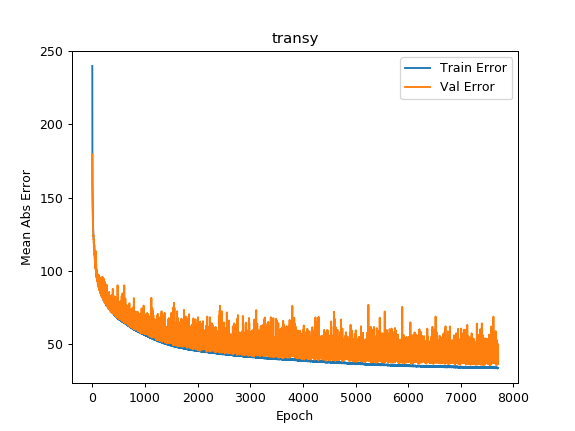

<IPython.core.display.Javascript object>


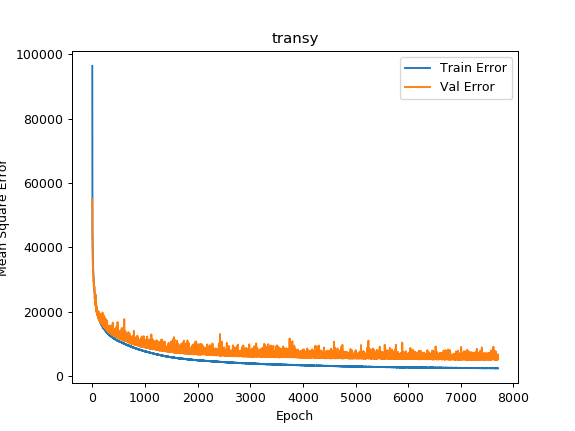

In [23]:
plot_history(histories['transy'], label="transy")

In [24]:
def show_results(label):
    loss, mae, mse = models[label].evaluate(normed_test_data, test_labels[label], verbose=0)

    print("Testing set Mean Abs Error: {:5.2f} um".format(mae))
    print("Testing set RMS: {:5.2f} um".format(np.sqrt(mse)))

    test_predictions = models[label].predict(normed_test_data).flatten()

    plt.scatter(test_labels[label], test_labels[label] - test_predictions)
    plt.xlabel('True Values [um]')
    plt.ylabel('Residuals [um]')
    minx, maxx = min(test_labels[label]), max(test_labels[label])
    plt.plot([minx, maxx], [0, 0])
    plt.show()

Testing set Mean Abs Error: 15.10 um
Testing set RMS: 30.31 um


<IPython.core.display.Javascript object>


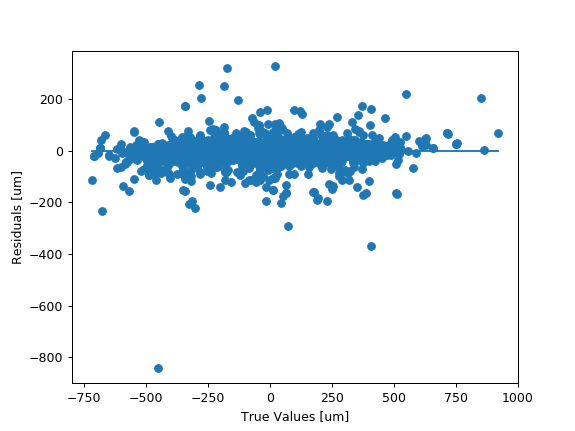

In [26]:
show_results('focus')

In [ ]:
lab = 'transx'
test_predictions = models[lab].predict(normed_test_data).flatten()
diff = test_labels[lab] - test_predictions
diff.idxmax(), diff.idxmin()

In [ ]:
test_labels[lab].idxmin()

In [ ]:
test_dataset.loc[6665]

In [ ]:
chk_data = normed_test_data[normed_test_data['f9'] > 0]
#chk.index
chk_test = test_labels['focus'][chk_data.index] 
chk_pred = models['focus'].predict(chk_data).flatten()
chk_diff = chk_test - chk_pred
chk_diff.std()

In [ ]:
chk_diff

In [ ]:
test_dataset.loc[3125]

In [ ]:
m = keras.models.load_model("/Users/tim/MMT/HALcoll/halcoll/data/tiltx_model.h5")

In [ ]:
m.evaluate(normed_test_data, test_labels['tiltx'])

In [ ]:
ttt = train_dataset['cell_e_series_chamber_ambient_C'] - train_dataset['yankee_temperature']
ttt.min()

In [ ]:
m = models['focus']

In [ ]:
m.summary()